# Statistical Analysis of Data

## Environment Settings

An statistical Analysis of the data captured will be performed.

The environment configuration is the following:

- A rectangle area is used whose dimension is 2 x 1.5 meters. 
- A custom robot similar to an epuck was used.
- The robot starts in the middle of the arena.
- The robot moves in a random fashion way around the environment avoiding obstacles.
- The robot has 8 sensors that measure the distance between the robot and the walls.
- Some noise was introduced in the sensors measurements of the robot using the concept of [lookup tables](https://cyberbotics.com/doc/reference/distancesensor) in the Webots simulator which according to Webots documentation "The first column of the table specifies the input distances, the second column specifies the corresponding desired response values, and the third column indicates the desired standard deviation of the noise. The noise on the return value is computed according to a gaussian random number distribution whose range is calculated as a percent of the response value (two times the standard deviation is often referred to as the signal quality)". The following values were taken:

    -First experiment:
        - (0, 0, 0.01)
        - (10, 10, 0.01)
    -Second experiment:
    
        - (0, 0, 0.2)
        - (10, 10, 0.2)
- The simulator runs during 10 minutes in fast mode which is translated into 12 hours of collected data.

In [2]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install keras

import pandas as pd
import tensorflow as tf
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from keras import models
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
from keras import optimizers

Using TensorFlow backend.


# First Experiment

In [3]:
csv_file = 'robot_info_dataset-jumped.csv'
df = pd.read_csv(csv_file)
df.head()

,Unnamed: 0,x,y,theta,dx,dy,dtheta,sensor_1,sensor_2,sensor_3,...,sensor_7,sensor_8,dsensor_1,dsensor_2,dsensor_3,dsensor_4,dsensor_5,dsensor_6,dsensor_7,dsensor_8
0,0,0.920614,0.761198,168.209483,-0.070670,0.011198,-11.790739,1.085179,0.790267,0.893342,...,1.139790,1.144901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.850135,0.775909,168.212418,-0.070479,0.014711,0.002935,0.571635,0.596799,0.883340,...,0.830057,1.028332,-0.513544,-0.193468,-0.010002,-0.430864,-0.070277,-0.387726,-0.309733,-0.116568
2,2,0.779657,0.790625,168.209551,-0.070478,0.014716,-0.002867,0.581452,0.904627,0.689004,...,0.491200,0.889130,0.009817,0.307828,-0.194336,0.239518,0.206480,0.293382,-0.338857,-0.139203
3,3,0.709174,0.805340,168.212871,-0.070483,0.014715,0.003319,0.956302,0.842911,0.796714,...,1.246415,0.712158,0.374849,-0.061716,0.107710,0.075412,-0.345782,-0.084918,0.755215,-0.176971
4,4,0.638698,0.820056,168.208857,-0.070477,0.014716,-0.004013,0.671731,0.779896,0.962191,...,0.567806,0.595164,-0.284570,-0.063014,0.165477,0.005216,0.128150,-0.054777,-0.678608,-0.116994


## Data pre-processing

The data collected 1384848 samples.

In [4]:
df.shape

(65342, 23)

The data set contains some null values so they should be deleted from the samples.

In [11]:
df = df.dropna()

Unnamed: 0    18862.466307
x                 0.496241
y                 0.349582
theta           104.663427
dx                0.051195
dy                0.048437
dtheta           81.707113
sensor_1          0.470150
sensor_2          0.505891
sensor_3          0.512642
sensor_4          0.462024
sensor_5          0.465292
sensor_6          0.513591
sensor_7          0.501790
sensor_8          0.459102
dsensor_1         0.417004
dsensor_2         0.397980
dsensor_3         0.415073
dsensor_4         0.408906
dsensor_5         0.407628
dsensor_6         0.401989
dsensor_7         0.381986
dsensor_8         0.408761
dtype: float64

Now the data will be normalized.

In [18]:
normalized_df=df
normalized_df.describe()

,Unnamed: 0,x,y,theta,dx,dy,dtheta,sensor_1,sensor_2,sensor_3,...,sensor_7,sensor_8,dsensor_1,dsensor_2,dsensor_3,dsensor_4,dsensor_5,dsensor_6,dsensor_7,dsensor_8
count,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,...,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,6.534100e+04,65341.000000,65341.000000,65341.000000
mean,32671.000000,0.991897,0.749435,180.741312,0.000008,0.000006,-0.002060,0.827380,0.842185,0.838310,...,0.806997,0.816321,-0.000007,-0.000004,0.000006,-0.000001,-1.064586e-07,-0.000011,-0.000014,-0.000012
std,18862.466307,0.496241,0.349582,104.663427,0.051195,0.048437,81.707113,0.470150,0.505891,0.512642,...,0.501790,0.459102,0.417004,0.397980,0.415073,0.408906,4.076285e-01,0.401989,0.381986,0.408761
min,1.000000,0.084585,0.081116,0.000752,-0.072387,-0.072347,-358.926393,0.025197,0.040579,0.048645,...,0.023785,0.039977,-2.395459,-2.541558,-2.754922,-2.653747,-2.586200e+00,-2.666227,-2.357037,-2.238793
25%,16336.000000,0.550289,0.437423,90.479241,-0.052238,-0.046163,-3.853159,0.450115,0.409818,0.408742,...,0.375082,0.447509,-0.199494,-0.177130,-0.163550,-0.155734,-1.518516e-01,-0.152624,-0.167310,-0.196313
50%,32671.000000,0.992291,0.747834,179.505793,0.000042,0.000062,-0.000189,0.749770,0.772644,0.766507,...,0.724673,0.744113,-0.034958,-0.007335,0.013334,0.028155,2.699703e-02,0.013224,-0.005916,-0.034660
75%,49006.000000,1.423504,1.061121,270.861352,0.052240,0.046400,3.837644,1.122047,1.187560,1.183412,...,1.146856,1.107448,0.159622,0.158696,0.178071,0.195229,1.907772e-01,0.168952,0.150002,0.156094
max,65341.000000,1.905325,1.405168,359.996294,0.072466,0.072241,356.597849,3.367954,3.435128,3.069116,...,3.140509,3.236260,2.933868,2.880298,2.606654,2.580241,2.394235e+00,2.347110,2.917931,3.011840


## Input and output variables

The data will be split into training, testing and validation sets. 60% of the data will be used for training, 20% for training and 20% of validation.

In [20]:

# train size
test_size_percentage = .2
train_size_percentage = .8
ds_size = normalized_df.shape[0]
train_size = int(train_size_percentage * ds_size)
test_size = int(test_size_percentage * ds_size)

# shuffle dataset
normalized_df = normalized_df.sample(frac=1)

# separate inputs from outputs
inputs = normalized_df[['x', 'y', 'theta']]
targets = normalized_df[['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8']]

# train
train_inputs = inputs[:train_size]
train_targets = targets[:train_size]

# test
test_inputs = inputs[train_size:(train_size + test_size)]
test_targets = targets[train_size:(train_size + test_size)]

# validation
validation_inputs = inputs[(train_size + test_size):]
validation_targets = targets[(train_size + test_size):]

## Neural Network


As input the neural network receives the x, y coordinates and rotation angle $\theta$. The output are the sensor measurements. One model per sensor will be created.

In [21]:

def get_model():
    # neural network with a 10-neuron hidden layer
    model = models.Sequential()
    model.add(layers.Dense(10, activation='relu', input_shape=(3,)))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='relu'))
    model.add(layers.Dense(3, activation='relu'))
    model.add(layers.Dense(1))
    
#     rmsprop = optimizers.RMSprop(learning_rate=0.01)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
              
    return model

In [22]:
train_targets[['sensor_1']][0:10]

,sensor_1
19364,1.074934
59584,1.924088
61341,1.337469
23702,2.238944
28425,1.143096
9182,2.065747
10540,0.684360
65284,0.667180
43348,0.413591
59742,1.640072


In [ ]:
def k_fold(sensor_number, num_epochs=10, k=5):
    num_val_samples = len(train_inputs) // k
    validation_scores = []
    histories = []
    nmse = []

    for i in range(k):
        print('processing fold #', i)
        val_data = train_inputs[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[[sensor_number]][i * num_val_samples: (i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [train_inputs[:i * num_val_samples],
             train_inputs[(i + 1) * num_val_samples:]], axis=0)
        partial_train_targets = np.concatenate(
            [train_targets[[sensor_number]][:i * num_val_samples],
             train_targets[[sensor_number]][(i + 1) * num_val_samples:]], axis=0)


        model = get_model()

        history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=1, verbose=1)
        histories.append(history.history)

        predictions_targets = model.predict(val_data)
        nmse.append(np.mean((predictions_targets - val_targets)**2)/np.var(val_targets))
        
    return histories, nmse


In [59]:
histories, nmse = k_fold('sensor_1', 150, 5)

processing fold # 0
Train on 31364 samples, validate on 7840 samples
Epoch 1/150
31364/31364 [==============================] - 38s 1ms/step - loss: 0.0116 - mae: 0.0814 - val_loss: 0.0067 - val_mae: 0.0624
Epoch 2/150
31364/31364 [==============================] - 35s 1ms/step - loss: 0.0069 - mae: 0.0615 - val_loss: 0.0058 - val_mae: 0.0576
Epoch 3/150
31364/31364 [==============================] - 36s 1ms/step - loss: 0.0065 - mae: 0.0602 - val_loss: 0.0058 - val_mae: 0.0556
Epoch 4/150
31364/31364 [==============================] - 37s 1ms/step - loss: 0.0064 - mae: 0.0598 - val_loss: 0.0076 - val_mae: 0.0702
Epoch 5/150
31364/31364 [==============================] - 37s 1ms/step - loss: 0.0064 - mae: 0.0594 - val_loss: 0.0059 - val_mae: 0.0583
Epoch 6/150
31364/31364 [==============================] - 36s 1ms/step - loss: 0.0064 - mae: 0.0593 - val_loss: 0.0068 - val_mae: 0.0641
Epoch 7/150
31364/31364 [==============================] - 37s 1ms/step - loss: 0.0060 - mae: 0.0578 - 

Epoch 118/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0048 - mae: 0.0515 - val_loss: 0.0062 - val_mae: 0.0606
Epoch 119/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0048 - mae: 0.0515 - val_loss: 0.0043 - val_mae: 0.0479
Epoch 120/150
31364/31364 [==============================] - 33s 1ms/step - loss: 0.0048 - mae: 0.0512 - val_loss: 0.0061 - val_mae: 0.0599
Epoch 121/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0048 - mae: 0.0513 - val_loss: 0.0059 - val_mae: 0.0591
Epoch 122/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0048 - mae: 0.0515 - val_loss: 0.0052 - val_mae: 0.0557
Epoch 123/150
31364/31364 [==============================] - 33s 1ms/step - loss: 0.0048 - mae: 0.0515 - val_loss: 0.0044 - val_mae: 0.0490
Epoch 124/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0048 - mae: 0.0516 - val_loss: 0.0054 - val_mae: 0.0548
Epoch 125/150
31364/

31364/31364 [==============================] - 34s 1ms/step - loss: 0.0053 - mae: 0.0539 - val_loss: 0.0049 - val_mae: 0.0510
Epoch 86/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0053 - mae: 0.0540 - val_loss: 0.0051 - val_mae: 0.0523
Epoch 87/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0053 - mae: 0.0540 - val_loss: 0.0057 - val_mae: 0.0576
Epoch 88/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0053 - mae: 0.0542 - val_loss: 0.0048 - val_mae: 0.0503
Epoch 89/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0053 - mae: 0.0539 - val_loss: 0.0071 - val_mae: 0.0618
Epoch 90/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0053 - mae: 0.0539 - val_loss: 0.0059 - val_mae: 0.0593
Epoch 91/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0053 - mae: 0.0540 - val_loss: 0.0052 - val_mae: 0.0517
Epoch 92/150
31364/31364 [==============

Epoch 144/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0057 - mae: 0.0563 - val_loss: 0.0075 - val_mae: 0.0636
Epoch 145/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0057 - mae: 0.0563 - val_loss: 0.0046 - val_mae: 0.0500
Epoch 146/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0058 - mae: 0.0566 - val_loss: 0.0052 - val_mae: 0.0538
Epoch 147/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0057 - mae: 0.0564 - val_loss: 0.0050 - val_mae: 0.0522
Epoch 148/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0058 - mae: 0.0568 - val_loss: 0.0049 - val_mae: 0.0519
Epoch 149/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0057 - mae: 0.0564 - val_loss: 0.0046 - val_mae: 0.0496
Epoch 150/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0057 - mae: 0.0564 - val_loss: 0.0071 - val_mae: 0.0656
processing fold # 2


Epoch 111/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0052 - mae: 0.0535 - val_loss: 0.0047 - val_mae: 0.0505
Epoch 112/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0052 - mae: 0.0535 - val_loss: 0.0053 - val_mae: 0.0546
Epoch 113/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0052 - mae: 0.0534 - val_loss: 0.0054 - val_mae: 0.0524
Epoch 114/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0052 - mae: 0.0532 - val_loss: 0.0050 - val_mae: 0.0523
Epoch 115/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0052 - mae: 0.0532 - val_loss: 0.0072 - val_mae: 0.0630
Epoch 116/150
31364/31364 [==============================] - 35s 1ms/step - loss: 0.0052 - mae: 0.0534 - val_loss: 0.0049 - val_mae: 0.0530
Epoch 117/150
31364/31364 [==============================] - 35s 1ms/step - loss: 0.0052 - mae: 0.0535 - val_loss: 0.0060 - val_mae: 0.0576
Epoch 118/150
31364/

31364/31364 [==============================] - 35s 1ms/step - loss: 0.0055 - mae: 0.0552 - val_loss: 0.0056 - val_mae: 0.0540
Epoch 79/150
31364/31364 [==============================] - 35s 1ms/step - loss: 0.0054 - mae: 0.0551 - val_loss: 0.0050 - val_mae: 0.0515
Epoch 80/150
31364/31364 [==============================] - 35s 1ms/step - loss: 0.0055 - mae: 0.0552 - val_loss: 0.0054 - val_mae: 0.0532
Epoch 81/150
31364/31364 [==============================] - 35s 1ms/step - loss: 0.0055 - mae: 0.0555 - val_loss: 0.0055 - val_mae: 0.0531
Epoch 82/150
31364/31364 [==============================] - 35s 1ms/step - loss: 0.0055 - mae: 0.0555 - val_loss: 0.0061 - val_mae: 0.0568
Epoch 83/150
31364/31364 [==============================] - 35s 1ms/step - loss: 0.0056 - mae: 0.0556 - val_loss: 0.0053 - val_mae: 0.0536
Epoch 84/150
31364/31364 [==============================] - 35s 1ms/step - loss: 0.0056 - mae: 0.0557 - val_loss: 0.0054 - val_mae: 0.0533
Epoch 85/150
31364/31364 [==============

Epoch 137/150
31364/31364 [==============================] - 35s 1ms/step - loss: 0.0060 - mae: 0.0576 - val_loss: 0.0055 - val_mae: 0.0539
Epoch 138/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0059 - mae: 0.0576 - val_loss: 0.0054 - val_mae: 0.0541
Epoch 139/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0059 - mae: 0.0576 - val_loss: 0.0063 - val_mae: 0.0576
Epoch 140/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0059 - mae: 0.0576 - val_loss: 0.0064 - val_mae: 0.0608
Epoch 141/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0059 - mae: 0.0575 - val_loss: 0.0062 - val_mae: 0.0589
Epoch 142/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0058 - mae: 0.0574 - val_loss: 0.0062 - val_mae: 0.0590
Epoch 143/150
31364/31364 [==============================] - 34s 1ms/step - loss: 0.0058 - mae: 0.0574 - val_loss: 0.0053 - val_mae: 0.0541
Epoch 144/150
31364/

31364/31364 [==============================] - 35s 1ms/step - loss: 0.0051 - mae: 0.0533 - val_loss: 0.0058 - val_mae: 0.0596
Epoch 105/150
31364/31364 [==============================] - 35s 1ms/step - loss: 0.0051 - mae: 0.0531 - val_loss: 0.0051 - val_mae: 0.0548
Epoch 106/150
31364/31364 [==============================] - 35s 1ms/step - loss: 0.0051 - mae: 0.0533 - val_loss: 0.0051 - val_mae: 0.0536
Epoch 107/150
31364/31364 [==============================] - 35s 1ms/step - loss: 0.0051 - mae: 0.0535 - val_loss: 0.0049 - val_mae: 0.0525
Epoch 108/150
31364/31364 [==============================] - 35s 1ms/step - loss: 0.0051 - mae: 0.0531 - val_loss: 0.0046 - val_mae: 0.0499
Epoch 109/150
31364/31364 [==============================] - 35s 1ms/step - loss: 0.0051 - mae: 0.0529 - val_loss: 0.0056 - val_mae: 0.0561
Epoch 110/150
31364/31364 [==============================] - 35s 1ms/step - loss: 0.0050 - mae: 0.0527 - val_loss: 0.0049 - val_mae: 0.0536
Epoch 111/150
31364/31364 [=======

NMSE: 
0.27307531306958077


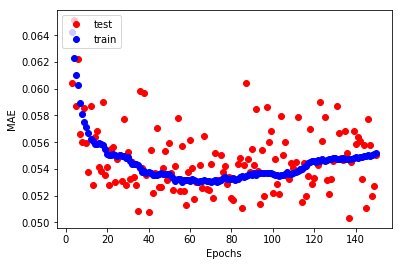

In [60]:
print("NMSE: ")
print(np.mean(nmse))

num_epochs = 150
val_mae_history = [np.mean([x['val_mae'][i] for x in histories]) for i in range(num_epochs)]
mae_history = [np.mean([x['mae'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(3, len(val_mae_history) + 1), val_mae_history[2:], 'ro')
plt.plot(range(3, len(mae_history) + 1), mae_history[2:], 'bo')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['test', 'train'], loc='upper left')
plt.show()


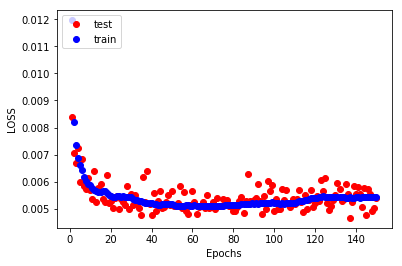

In [61]:
val_loss_history = [np.mean([x['val_loss'][i] for x in histories]) for i in range(num_epochs)]
loss_history = [np.mean([x['loss'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, 'ro')
plt.plot(range(1, len(loss_history) + 1), loss_history, 'bo')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(['test', 'train'], loc='upper left')
plt.show()

In [23]:
model = get_model()

history = model.fit(inputs, targets[['sensor_1']], epochs=75, batch_size=1, verbose=1)
history.history['mae']
model.save("nn_sensor_1.h5")

Epoch 1/75
65341/65341 [==============================] - 62s 952us/step - loss: 0.5954 - mae: 0.4011
Epoch 2/75
65341/65341 [==============================] - 62s 950us/step - loss: 0.2145 - mae: 0.3679
Epoch 3/75
65341/65341 [==============================] - 64s 986us/step - loss: 0.2106 - mae: 0.36481s - loss: 
Epoch 4/75
65341/65341 [==============================] - 63s 966us/step - loss: 0.2069 - mae: 0.3610
Epoch 5/75
65341/65341 [==============================] - 59s 908us/step - loss: 0.1923 - mae: 0.3435
Epoch 6/75
65341/65341 [==============================] - 63s 964us/step - loss: 0.1863 - mae: 0.3365
Epoch 7/75
65341/65341 [==============================] - 67s 1ms/step - loss: 0.1833 - mae: 0.3330
Epoch 8/75
65341/65341 [==============================] - 65s 993us/step - loss: 0.1768 - mae: 0.3249
Epoch 9/75
65341/65341 [==============================] - 63s 968us/step - loss: 0.1737 - mae: 0.3204
Epoch 10/75
65341/65341 [==============================] - 85s 1ms/step -